# RXTE example

This notebook demonstrates an analysis of 16 years of RXTE data, which would be difficult outside of SciServer.  We extract all of the standard product lightcurves, but then we decide that we need different channel boundaries.  So we re-exctract light curves following the RXTE documentation and using the heasoftpy wrappers.  

In [1]:
import sys,os, shutil
import pyvo as vo
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline  
import astropy.io.fits as pyfits
import datetime
#from tqdm import tqdm

In [2]:
## Until integrated with heasoft
os.environ["HEADASNOQUERY"]="True"

import heasoftpy as hsp

### Step 1:  find the data

We can use the Virtual Observatory interfaces to the HEASARC to find the data we're  interested in.  Specifically, we want to look at the observation tables.  So first we get a list of all the tables HEASARC serves and then look for the ones related to RXTE:

In [3]:
tap_services=vo.regsearch(servicetype='table',keywords=['heasarc'])
heasarc_tables=tap_services[0].service.tables

In [4]:
for tablename in heasarc_tables.keys():
    if "xte" in tablename:  
        print(" {:20s} {}".format(tablename,heasarc_tables[tablename].description))


 xteao                XTE Proposal Info & Abstracts
 xteasmlong           XTE All-Sky Monitor Long-Term Observed Sources
 xteassagn            XTE All-Sky Slew Survey AGN Catalog
 xteasscat            XTE All-Sky Slew Survey Catalog
 xteindex             XTE Target Index Catalog
 xtemaster            XTE Master Catalog
 xtemlcat             XTE Mission-Long Source Catalog
 xteslew              XTE Archived Public Slew Data


The "xtemaster" catalog is the one that we're interested in.  

Let's see what this table has in it.  Alternatively, we can google it and find the same information here:

https://heasarc.gsfc.nasa.gov/W3Browse/all/xtemaster.html


In [5]:
for c in heasarc_tables['xtemaster'].columns:
    print("{:20s} {}".format(c.name,c.description))

pi_lname             Principal Investigator Last Name
target_name          Target Name
hexte_angleb         HEXTE Angle B
hexte_anglea         HEXTE Angle A
cycle                Proposal Cycle Number
hexte_energya        HEXTE Energy A
hexte_energyb        HEXTE Energy B
pca_config4          PCA Configuration 4
priority             Target Priority
"__row"              System index column
lii                  Galactic Longitude
hexte_modea          HEXTE Mode A
"time"               Start Date of Observation
pca_config3          PCA Configuration 3
status               Status: accepted, sched (long), sched (short), observed, processed, or archived
obsid                Observation ID of Scheduled Observation
pi_fname             Principal Investigator First Name
tar_no               Target Number
pi_no                Principal Investigator Unique Number
observed_date        Start Date of Observation
pca_config1          PCA Configuration 1
pca_config2          PCA Configuration 2
pca_conf

We're interested in Eta Carinae, and we want to get the RXTE cycle, proposal, and observation ID etc. for every observation it took of this source based on its position.  (Just in case the name has been entered differently, which can happen.)  This constructs a query in the ADQL language to select the columns (target_name, cycle, prnb, obsid, time, exposure, ra, dec) where the point defined by the observation's RA and DEC lies inside a circle defined by our chosen source position.  The results will be sorted by time.  See the [NAVO website](https://heasarc.gsfc.nasa.gov/vo/summary/python.html) for more information on how to use these services with python and how to construct ADQL queries for catalog searches.

In [6]:
# Get the coordinate for Eta Car
import astropy.coordinates as coord
pos=coord.SkyCoord.from_name("eta car")
query="""SELECT target_name, cycle, prnb, obsid, 
         observed_date-50000 as day, time, exposure
    FROM public.xtemaster as cat 
    where 
    contains(point('ICRS',cat.ra,cat.dec),circle('ICRS',{},{},0.1))=1 
    and 
    cat.exposure > 0 order by cat.time
    """.format(pos.ra.deg, pos.dec.deg)

In [7]:
results=tap_services[0].search(query).to_table()
results

target_name,cycle,prnb,obsid,day,time,exposure
,,,,,mjd,s
object,int16,int32,object,float64,float64,float64
ETA_CAR,1,10004,10004-01-40-00,122.6426300000021,50122.64263,1091
ETA_CAR,1,10004,10004-01-39-00,129.4299200000023,50129.42992,945
ETA_CAR,1,10004,10004-01-38-00,134.57052999999723,50134.57053,1018
ETA_CAR,1,10004,10004-01-41-00,142.85057999999844,50142.85058,958
ETA_CAR,1,10004,10004-01-37-00,147.831339999997,50147.83134,1778
ETA_CAR,1,10004,10004-01-36-00,150.58692000000156,50150.58692,696
ETA_CAR,1,10004,10004-01-36-01,154.99083999999857,50154.99084,1098
ETA_CAR,1,10004,10004-01-35-00,162.75742999999784,50162.75743,1109


Let's just see how long these observations are:

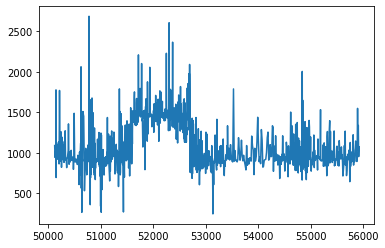

In [8]:
plt.plot(results['time'],results['exposure'])

###  Step 2:  combine standard products and plot

Let's collect all the standard product light curves for RXTE.  (These are described on the [RXTE analysis pages](https://heasarc.gsfc.nasa.gov/docs/xte/recipes/cook_book.html).)

In [9]:
## Need cycle number as well, since after AO9, 
##  no longer 1st digit of proposal number
ids=np.unique( results['cycle','prnb','obsid','time'])
ids.sort(order='time')
ids

array([( 1, 10004, '10004-01-40-00', 50122.64263),
       ( 1, 10004, '10004-01-39-00', 50129.42992),
       ( 1, 10004, '10004-01-38-00', 50134.57053), ...,
       (15, 96002, '96002-01-50-00', 55909.92591),
       (15, 96002, '96002-01-51-00', 55916.80008),
       (15, 96002, '96002-01-52-00', 55923.7098 )],
      dtype=[('cycle', '<i2'), ('prnb', '<i4'), ('obsid', 'O'), ('time', '<f8')])

In [10]:
## Construct a file list.
##  In this case, the name changes
import glob
# Though Jupyter Lab container
rootdir="/FTP"
# Through batch ?
#rootdir="/home/idies/workspace/HEASARC\ data"
rxtedata="rxte/data/archive"
filenames=[]
for (k,val) in enumerate(ids['obsid']):
    fname="{}/{}/AO{}/P{}/{}/stdprod/xp{}_n2a.lc.gz".format(
        rootdir,
        rxtedata,
        ids['cycle'][k],
        ids['prnb'][k],
        ids['obsid'][k],
        ids['obsid'][k].replace('-',''))
    #print(fname)
    f=glob.glob(fname)
    if (len(f) > 0):
        filenames.append(f[0])
print("Found {} out of {} files".format(len(filenames),len(ids)))

Found 1364 out of 1368 files


Let's collect them all into one light curve:

In [11]:
hdul = fits.open(filenames.pop(0))
data = hdul[1].data
cnt=0
for f in filenames:
    hdul = fits.open(f)
    d = hdul[1].data
    data=np.hstack([data,d])
    if cnt % 100 == 0:
        print("On file {}".format(f))
        print("   adding {} rows from TSTART={}".format(d.shape[0],hdul[1].header['TSTARTI']))
    cnt+=1
## The above LCs are merged per proposal.  You can see that some proposals
##  had data added later, after other proposals, so you need to sort:
data.sort(order='TIME')


On file /FTP/rxte/data/archive/AO1/P10004/10004-01-39-00/stdprod/xp10004013900_n2a.lc.gz
   adding 58 rows from TSTART=67083939
On file /FTP/rxte/data/archive/AO2/P20003/20003-01-34-00/stdprod/xp20003013400_n2a.lc.gz
   adding 55 rows from TSTART=112362067
On file /FTP/rxte/data/archive/AO3/P30006/30006-03-02-00/stdprod/xp30006030200_n2a.lc.gz
   adding 56 rows from TSTART=134573827
On file /FTP/rxte/data/archive/AO4/P40003/40003-01-33-00/stdprod/xp40003013300_n2a.lc.gz
   adding 65 rows from TSTART=168957235
On file /FTP/rxte/data/archive/AO5/P50003/50003-01-28-00/stdprod/xp50003012800_n2a.lc.gz
   adding 90 rows from TSTART=204122819
On file /FTP/rxte/data/archive/AO6/P60003/60003-01-28-00/stdprod/xp60003012800_n2a.lc.gz
   adding 92 rows from TSTART=239054019
On file /FTP/rxte/data/archive/AO7/P70001/70001-01-51-00/stdprod/xp70001015100_n2a.lc.gz
   adding 88 rows from TSTART=272790707
On file /FTP/rxte/data/archive/AO8/P80001/80001-01-36-00/stdprod/xp80001013600_n2a.lc.gz
   adding

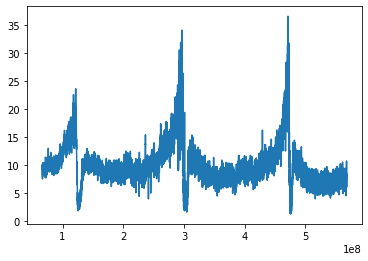

In [12]:
plt.plot(data['TIME'],data['RATE'])


### Step 3:  Re-extract a light-curve

Now we go out and read about how to analyze RXTE data, and we decide that we need different channel boundaries than were used in the standard products.  We can write a little function that does the RXTE data analysis steps for every observation to extract a lightcurve and read it into memory to recreate the above dataset.  This function may look complicated, but it only calls three RXTE executables:

* pcaprepobsid
* maketime
* pcaextlc2

which extracts the Standard mode 2 data (not to be confused with the "standard products") for the channels you're interested in.  It has a bit of error checking that'll help when launching a long job.

Note that each call to this function will take 10-20 seconds to complete.  So when we run a whole proposal, we'll have to wait a while. 

In [13]:

class XlcError( Exception ):
    pass


#  Define a function that, given an ObsID, does the rxte light curve extraction
def rxte_lc( obsid=None, ao=None , chmin=None, chmax=None, cleanup=True):
    rootdir="/FTP"
    rxtedata="rxte/data/archive"
    obsdir="{}/{}/AO{}/P{}/{}/".format(
        rootdir,
        rxtedata,
        ao,
        obsid[0:5],
        obsid
    )
    #print("Looking for obsdir={}".format(obsdir))
    outdir="tmp.{}".format(obsid)
    if (not os.path.isdir(outdir)):
        os.mkdir(outdir)

    if cleanup and os.path.isdir(outdir):
        shutil.rmtree(outdir,ignore_errors=True)

    try:
        #print("Running pcaprepobsid")
        result=hsp.pcaprepobsid(indir=obsdir,
                                outdir=outdir
                               )
        print(result.stdout)
        #  This one doesn't seem to return correctly, so this doesn't trap!
        if result.returncode != 0:
            raise XlcError("pcaprepobsid returned status {}".format(result.returncode))
    except:
        raise
    # Recommended filter from RTE Cookbook pages:
    filt_expr = "(ELV > 4) && (OFFSET < 0.1) && (NUM_PCU_ON > 0) && .NOT. ISNULL(ELV) && (NUM_PCU_ON < 6)"
    try:
        filt_file=glob.glob(outdir+"/FP_*.xfl")[0]
    except:
        raise XlcError("pcaprepobsid doesn't seem to have made a filter file!")

    try:
        #print("Running maketime")
        result=hsp.maketime(infile=filt_file, 
                            outfile=os.path.join(outdir,'rxte_example.gti'),
                            expr=filt_expr, name='NAME', 
                            value='VALUE', 
                            time='TIME', 
                            compact='NO')
        #print(result.stdout)
        if result.returncode != 0:
            raise XlcError("maketime returned status {}".format(result.returncode))
    except:
        raise
      
    try:
        #print("Running pcaextlc2")
        result=hsp.pcaextlc2(src_infile="@{}/FP_dtstd2.lis".format(outdir),
                             bkg_infile="@{}/FP_dtbkg2.lis".format(outdir),
                             outfile=os.path.join(outdir,'rxte_example.lc'), 
                             gtiandfile=os.path.join(outdir,'rxte_example.gti'),
                             chmin=chmin,
                             chmax=chmax,
                             pculist='ALL', layerlist='ALL', binsz=16)
        #print(result.stdout)
        if result.returncode != 0:
            raise XlcError("pcaextlc2 returned status {}".format(result.returncode))
    except:
        raise

    with pyfits.open(os.path.join(outdir,'rxte_example.lc'),memmap=False) as hdul:
        lc=hdul[1].data
    if cleanup:
        shutil.rmtree(outdir,ignore_errors=True)
    return lc


Let's look just at a small part of the time range, and look at only the first few for speed:

In [14]:
break_at=10
for (k,val) in enumerate(ids):
    if k>break_at:  break
    l=rxte_lc(ao=val['cycle'], obsid=val['obsid'], chmin=5,chmax=10)    
    try:
        lc=np.hstack([lc,l])
    except:
        lc=l
        

Running pcaprepobsid v1.3
----------------------------------------
10004-01-40-00 1996-02-09T15:29:45 1996-02-09T15:48:13
  FILT: tmp.10004-01-40-00/FP_03f6ab29-03f6af7d.xfl
  OBJECT: 'ETA_CAR' (RA=161.26,DEC=-59.68)
  STD2: /FTP/rxte/data/archive/AO1/P10004/10004-01-40-00//pca/FS4a_3f6ab29-3f6af7d.gz
  STD1: /FTP/rxte/data/archive/AO1/P10004/10004-01-40-00//pca/FS46_3f6ab29-3f6af7d.gz

Running pcaprepobsid v1.3
----------------------------------------
10004-01-39-00 1996-02-16T10:26:10 1996-02-16T10:42:13
  FILT: tmp.10004-01-39-00/FP_03ff9e82-03ffa245.xfl
  OBJECT: 'ETA_CAR' (RA=161.26,DEC=-59.68)
  STD2: /FTP/rxte/data/archive/AO1/P10004/10004-01-39-00//pca/FS4a_3ff9e82-3ffa245.gz
  STD1: /FTP/rxte/data/archive/AO1/P10004/10004-01-39-00//pca/FS46_3ff9e82-3ffa245.gz

Running pcaprepobsid v1.3
----------------------------------------
10004-01-38-00 1996-02-21T13:49:07 1996-02-21T14:09:13
  FILT: tmp.10004-01-38-00/FP_04066593-04066a49.xfl
  OBJECT: 'ETA_CAR' (RA=161.26,DEC=-59.68)
  S

In [15]:
# Because the obsids won't necessarily be processed in time order
lc.sort(order='TIME')

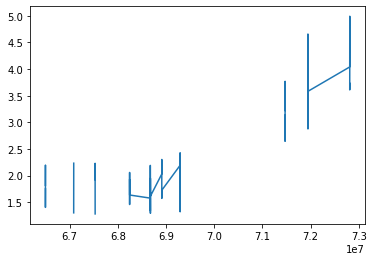

In [16]:
plt.plot(lc['TIME'],lc['RATE'])

In [17]:
hdu = pyfits.BinTableHDU(lc)
pyfits.HDUList([pyfits.PrimaryHDU(),hdu]).writeto('eta_car.lc',overwrite=True)


You could then remove the break in the above loop and submit this job to the [batch queue](https://apps.sciserver.org/compute/jobs).